2023-11-20 01:00:50.388465: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


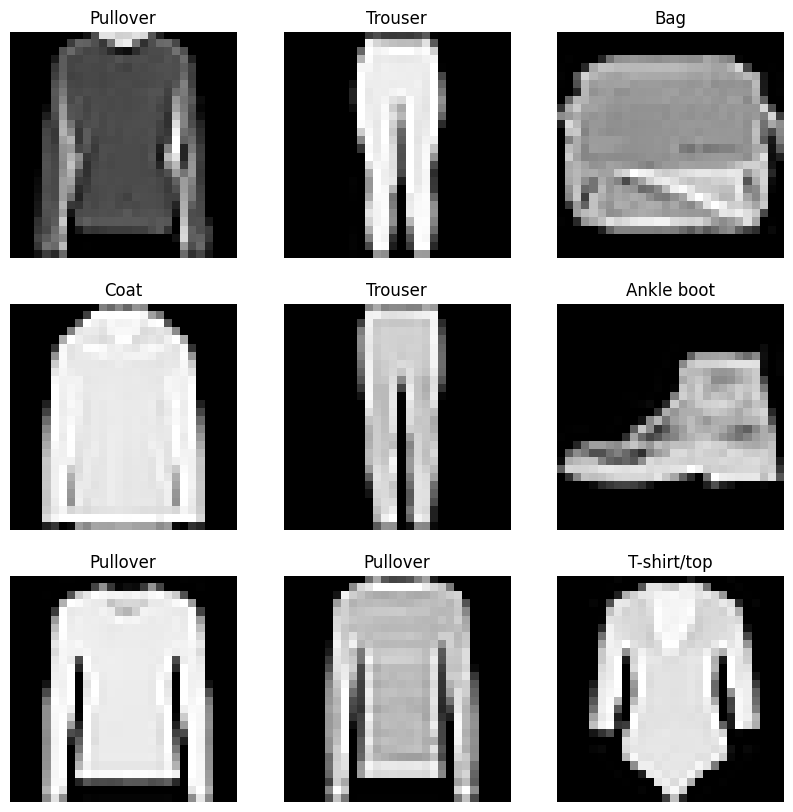

In [12]:
# Import the necessary modules
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

# Define the hyperparameters
batch_size = 128
num_epochs = 30

# Load the Fashion MNIST dataset
transform = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
trainset = tfds.load('fashion_mnist', split='train', as_supervised=True).map(lambda x, y: (transform(x), y)).batch(batch_size)
testset = tfds.load('fashion_mnist', split='test', as_supervised=True).map(lambda x, y: (transform(x), y)).batch(batch_size)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# preview the dataset
for image, label in trainset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i], cmap='gray')
        plt.title(classes[label[i]])
        plt.axis('off')
    plt.show()

In [3]:
# summary the size of the dataset
print(trainset.cardinality().numpy()*batch_size)
print(testset.cardinality().numpy()*batch_size)
# the dimension of the dataset
print(image.shape)

60032
10112
(128, 28, 28, 1)


In [13]:
# Define the teacher model (a small convolutional neural network)
class Teacher(tf.keras.Model):
    def __init__(self):
        super(Teacher, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(2, 2)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(64, activation='relu')
        self.fc4 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.pool1(self.conv1(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# Define another teacher model (a small deep neural network)
class Teacher_DNN(tf.keras.Model):
    def __init__(self):
        super(Teacher_DNN, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(64, activation='relu')
        self.fc4 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# Define the student model (a smaller fully-connected neural network)
class Student_Simple(tf.keras.Model):
    def __init__(self):
        super(Student_Simple, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(2000, activation = 'relu')
        self.fc2 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


class Student_Mimic(tf.keras.Model):
    def __init__(self):
        super(Student_Mimic, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        # bottleneck layer
        self.fc1 = tf.keras.layers.Dense(10, activation='linear')
        self.fc2 = tf.keras.layers.Dense(2000, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

Epoch 1/15
469/469 [==============================] - 50s 81ms/step - loss: 0.6789 - accuracy: 0.7516 - val_loss: 0.4797 - val_accuracy: 0.8288
Epoch 2/15
469/469 [==============================] - 29s 62ms/step - loss: 0.4152 - accuracy: 0.8495 - val_loss: 0.3944 - val_accuracy: 0.8605
Epoch 3/15
469/469 [==============================] - 37s 80ms/step - loss: 0.3538 - accuracy: 0.8726 - val_loss: 0.3522 - val_accuracy: 0.8749
Epoch 4/15
469/469 [==============================] - 38s 81ms/step - loss: 0.3177 - accuracy: 0.8841 - val_loss: 0.3186 - val_accuracy: 0.8868
Epoch 5/15
469/469 [==============================] - 35s 74ms/step - loss: 0.2917 - accuracy: 0.8940 - val_loss: 0.3001 - val_accuracy: 0.8911
Epoch 6/15
469/469 [==============================] - 22s 46ms/step - loss: 0.2705 - accuracy: 0.9015 - val_loss: 0.2893 - val_accuracy: 0.8967
Epoch 7/15
469/469 [==============================] - 16s 34ms/step - loss: 0.2533 - accuracy: 0.9073 - val_loss: 0.2837 - val_accuracy:

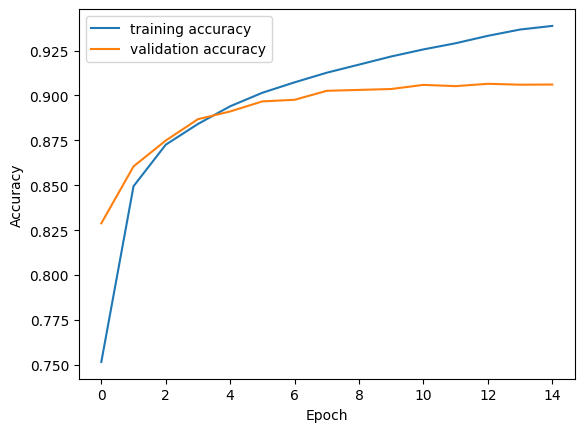

The best epoch is 13
INFO:tensorflow:Assets written to: teacher_cnn/assets


INFO:tensorflow:Assets written to: teacher_cnn/assets


79/79 [==============================] - 1s 12ms/step - loss: 0.2800 - accuracy: 0.9061
Accuracy of the teacher model on the test set: 90.61 %


<Figure size 640x480 with 0 Axes>

In [17]:
num_epochs = 15
# Instantiate the models
teacher_cnn = Teacher()

# train the teacher CNN model
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the teacher model on the original hard targets
teacher_cnn.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
teacher_cnn.fit(trainset, epochs=num_epochs, validation_data=testset)
print('Finished training the teacher model')

# visualize the training process
plt.plot(teacher_cnn.history.history['accuracy'], label='training accuracy')
plt.plot(teacher_cnn.history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('teacher_cnn.png')

# take the epoch with highest validation accuracy as the final model
best_epoch = teacher_cnn.history.history['val_accuracy'].index(max(teacher_cnn.history.history['val_accuracy'])) + 1
print('The best epoch is %d' % best_epoch)
# store the best model
if num_epochs == best_epoch:
    teacher_cnn.save('teacher_cnn', save_format='tf', overwrite=True, include_optimizer=True)

# Evaluate the teacher model on the test set
teacher_cnn.evaluate(testset)
print('Accuracy of the teacher model on the test set: %.2f %%' % (teacher_cnn.metrics[-1].result() * 100))

Epoch 1/50
469/469 [==============================] - 7s 10ms/step - loss: 0.6947 - accuracy: 0.7573 - val_loss: 0.4889 - val_accuracy: 0.8291
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.4443 - accuracy: 0.8417 - val_loss: 0.4437 - val_accuracy: 0.8434
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3985 - accuracy: 0.8565 - val_loss: 0.4311 - val_accuracy: 0.8480
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3702 - accuracy: 0.8659 - val_loss: 0.4180 - val_accuracy: 0.8519
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3511 - accuracy: 0.8727 - val_loss: 0.4020 - val_accuracy: 0.8579
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.3360 - accuracy: 0.8776 - val_loss: 0.3853 - val_accuracy: 0.8626
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3232 - accuracy: 0.8813 - val_loss: 0.3833 - val_accuracy: 0.8632
Epoch

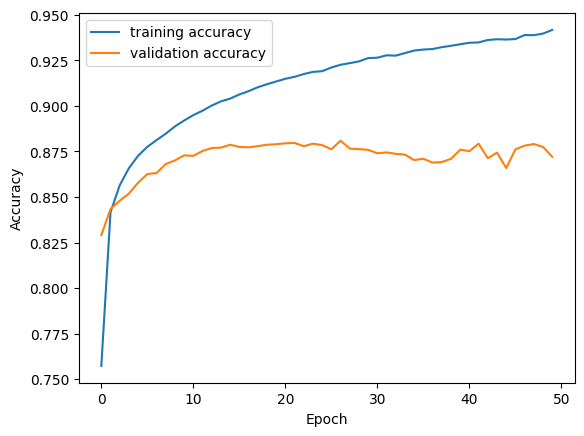

79/79 [==============================] - 1s 7ms/step - loss: 0.4788 - accuracy: 0.8721
Accuracy of the teacher model on the test set: 87.21 %


<Figure size 640x480 with 0 Axes>

In [18]:
num_epochs = 50
# Instantiate the model
teacher_dnn = Teacher_DNN()

# train the teacher DNN model
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the teacher model on the original hard targets
teacher_dnn.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
teacher_dnn.fit(trainset, epochs=num_epochs, validation_data=testset)
print('Finished training the teacher model')

# visualize the training process
plt.plot(teacher_dnn.history.history['accuracy'], label='training accuracy')
plt.plot(teacher_dnn.history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('teacher_dnn.png')

# Evaluate the teacher model on the test set
teacher_dnn.evaluate(testset)
print('Accuracy of the teacher model on the test set: %.2f %%' % (teacher_dnn.metrics[-1].result() * 100))

In [ ]:
# load the teacher model
teacher_cnn = tf.keras.models.load_model('teacher_cnn')

teacher_cnn.summary()

Model: "teacher_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  160       
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_26 (Dense)            multiple                  200768    
                                                                 
 dense_27 (Dense)            multiple                  4160      
                                                                 
 dense_28 (Dense)            multiple                  4160      
                                                         

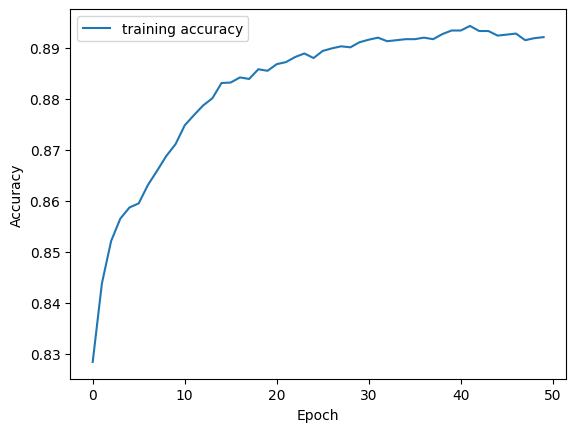

79/79 [==============================] - 1s 8ms/step - loss: 0.3324 - accuracy: 0.8921
Accuracy of the simple student model on the test set: 89.21 %


<Figure size 640x480 with 0 Axes>

In [21]:
# Instantiate the student model
student_simple = Student_Simple()
# Train the student model on the original hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# initialize the epoch and accuracy in a dictionary
result_simple = {'epoch': [], 'accuracy': []}

# Train the student model on the original hard targets from the teacher model
student_simple.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = student_simple(inputs)
            # with tf.GradientTape(watch_accessed_variables=False) as tape2:
            #     tape2.watch(outputs)
            #     teacher_outputs = teacher_cnn(inputs)
            # Compute the hard loss
            loss = criterion(labels, outputs)
        # Apply the gradients
        grads = tape.gradient(loss, student_simple.trainable_variables)
        optimizer.apply_gradients(zip(grads, student_simple.trainable_variables))
        running_loss += loss.numpy()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    # Evaluate the simple student model on the test set
    student_simple.evaluate(testset)
    # store the accuracy and epoch
    result_simple['epoch'].append(epoch)
    result_simple['accuracy'].append(student_simple.metrics[-1].result().numpy())

print('Finished training the simple student model')

# visualize the training process
plt.plot(result_simple['epoch'], result_simple['accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('student_simple.png')

# Evaluate the simple student model on the test set
student_simple.evaluate(testset)
print('Accuracy of the simple student model on the test set: %.2f %%' % (student_simple.metrics[-1].result() * 100))

In [ ]:
# Instantiate the student model
student_simple = Student_Simple()
# Train the student model on the original hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# initialize the epoch and accuracy in a dictionary
result_simple = {'epoch': [], 'accuracy': []}

# Train the student model on the original hard targets from the teacher model
student_simple.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = student_simple(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the KL loss
            loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature))
        # Apply the gradients
        grads = tape.gradient(loss, student_simple.trainable_variables)
        optimizer.apply_gradients(zip(grads, student_simple.trainable_variables))
        running_loss += loss.numpy()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    # Evaluate the simple student model on the test set
    student_simple.evaluate(testset)
    # store the accuracy and epoch
    result_simple['epoch'].append(epoch)
    result_simple['accuracy'].append(student_simple.metrics[-1].result().numpy())

print('Finished training the simple student model')

# visualize the training process
plt.plot(result_simple['epoch'], result_simple['accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('student_simple.png')

# Evaluate the simple student model on the test set
student_simple.evaluate(testset)
print('Accuracy of the simple student model on the test set: %.2f %%' % (student_simple.metrics[-1].result() * 100))

[1,   200] loss: 0.256
[1,   400] loss: 0.232
79/79 [==============================] - 2s 6ms/step - loss: 1.8303 - accuracy: 0.3608
[2,   200] loss: 0.180
[2,   400] loss: 0.141
79/79 [==============================] - 1s 6ms/step - loss: 1.4356 - accuracy: 0.3912
[3,   200] loss: 0.114
[3,   400] loss: 0.103
79/79 [==============================] - 0s 5ms/step - loss: 1.2144 - accuracy: 0.5200
[4,   200] loss: 0.093
[4,   400] loss: 0.087
79/79 [==============================] - 1s 7ms/step - loss: 1.0132 - accuracy: 0.6005
[5,   200] loss: 0.079
[5,   400] loss: 0.075
79/79 [==============================] - 0s 4ms/step - loss: 0.9244 - accuracy: 0.6408
[6,   200] loss: 0.069
[6,   400] loss: 0.066
79/79 [==============================] - 1s 7ms/step - loss: 0.8854 - accuracy: 0.6804
[7,   200] loss: 0.061
[7,   400] loss: 0.059
79/79 [==============================] - 0s 6ms/step - loss: 0.8626 - accuracy: 0.7063
[8,   200] loss: 0.055
[8,   400] loss: 0.052
79/79 [================

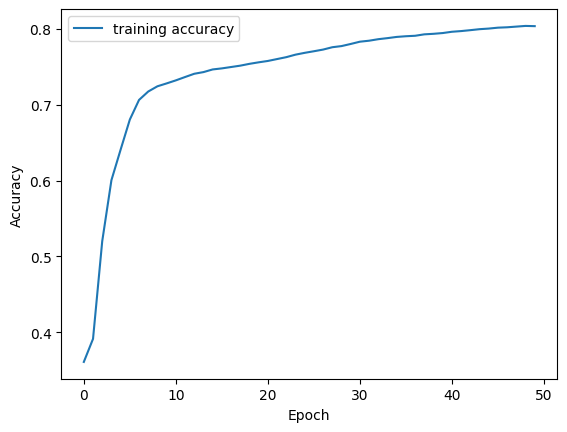

79/79 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.8036
Accuracy of the student model on the test set: 80.36 %


<Figure size 640x480 with 0 Axes>

In [31]:
# Instantiate the model
student_mimic = Student_Mimic()

alpha = 0.9
temperature = 1
# instantiate the epoch and accuracy in a dictionary
result_mimic = {'epoch': [], 'accuracy': []}

# Train the student model on the combined soft and hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Get the full list of trainable variables
trainable_variables = student_mimic.trainable_variables

# Build the optimizer with the full list of trainable variables
optimizer.build(trainable_variables)

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the student model on the soft targets from the teacher model
student_mimic.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = student_mimic(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the soft loss and the hard loss
            KL_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature))
            # hard_loss = criterion(labels, outputs)
            # L2_loss = tf.keras.losses.MSE(teacher_outputs, outputs)
            # Combine the soft loss and the hard loss with a weighting factor
            # loss = alpha * soft_loss + (1 - alpha) * hard_loss
            loss = KL_loss
        # Apply the gradients
        grads = tape.gradient(loss, student_mimic.trainable_variables)
        optimizer.apply_gradients(zip(grads, student_mimic.trainable_variables))
        running_loss += loss.numpy()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    # Evaluate the student model on the test set
    student_mimic.evaluate(testset)
    # store the accuracy and epoch
    result_mimic['epoch'].append(epoch)
    result_mimic['accuracy'].append(student_mimic.metrics[-1].result().numpy())

print('Finished training the student model')

# visualize the training process
plt.plot(result_mimic['epoch'], result_mimic['accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('student_mimic.png')


# Evaluate the student model on the test set
student_mimic.evaluate(testset)
print('Accuracy of the student model on the test set: %.2f %%' % (student_mimic.metrics[-1].result() * 100))


[1,   200] loss: 0.081
[1,   400] loss: 0.079
79/79 [==============================] - 1s 5ms/step - loss: 2.0862 - accuracy: 0.3314
[2,   200] loss: 0.074
[2,   400] loss: 0.067
79/79 [==============================] - 0s 6ms/step - loss: 1.5237 - accuracy: 0.5228
[3,   200] loss: 0.052
[3,   400] loss: 0.044
79/79 [==============================] - 0s 4ms/step - loss: 1.0433 - accuracy: 0.6443
[4,   200] loss: 0.037
[4,   400] loss: 0.035
79/79 [==============================] - 0s 6ms/step - loss: 0.8793 - accuracy: 0.6854
[5,   200] loss: 0.031
[5,   400] loss: 0.030
79/79 [==============================] - 1s 6ms/step - loss: 0.7969 - accuracy: 0.7197
[6,   200] loss: 0.028
[6,   400] loss: 0.027
79/79 [==============================] - 1s 6ms/step - loss: 0.7388 - accuracy: 0.7477
[7,   200] loss: 0.025
[7,   400] loss: 0.024
79/79 [==============================] - 1s 8ms/step - loss: 0.6959 - accuracy: 0.7636
[8,   200] loss: 0.023
[8,   400] loss: 0.022
79/79 [================

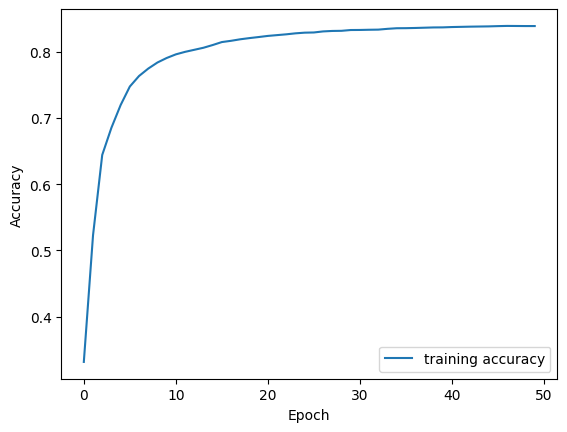

79/79 [==============================] - 0s 5ms/step - loss: 0.4754 - accuracy: 0.8391
Accuracy of the student model on the test set: 83.91 %


<Figure size 640x480 with 0 Axes>

In [41]:
# Instantiate the model
student_mimic = Student_Mimic()

temperature = 1
# instantiate the epoch and accuracy in a dictionary
result_mimic = {'epoch': [], 'accuracy': []}

# Train the student model on the combined soft and hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Get the full list of trainable variables
trainable_variables = student_mimic.trainable_variables

# Build the optimizer with the full list of trainable variables
optimizer.build(trainable_variables)

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the student model on the soft targets from the teacher model
student_mimic.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = student_mimic(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the soft loss and the hard loss
            # KL_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature))
            L2_loss = tf.reduce_mean(tf.keras.losses.MSE(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature)))
            loss = L2_loss
        # Apply the gradients
        grads = tape.gradient(loss, student_mimic.trainable_variables)
        optimizer.apply_gradients(zip(grads, student_mimic.trainable_variables))
        running_loss += loss.numpy()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    # Evaluate the student model on the test set
    student_mimic.evaluate(testset)
    # store the accuracy and epoch
    result_mimic['epoch'].append(epoch)
    result_mimic['accuracy'].append(student_mimic.metrics[-1].result().numpy())

print('Finished training the student model')

# visualize the training process
plt.plot(result_mimic['epoch'], result_mimic['accuracy'], label='training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('student_mimic_L2_loss.png')


# Evaluate the student model on the test set
student_mimic.evaluate(testset)
print('Accuracy of the student model on the test set: %.2f %%' % (student_mimic.metrics[-1].result() * 100))
